# Цель проекта

Данный проект делался в рамках обучения и его целью является закрепить навыки комьютерного зрения при работе с фреймворком Keras. Создание реально эффективной модели, которую можно использовать для описанной задачи в проекте не является целью этого проекта. Цель, создать настолько хорошую модель насколько получится используя Keras и сделать выводы по ней.

# Поиск по изображениям

# Содержание

- [Введение](#intro)
  - [Описание данных](#data)
- [Анализ](#analysis)
  - [Вывод по анализу](#analysis_conclusion)
- [Предобработка](#preprocessing)
  - [Вывод по предобработке](#preprocessing_conclusion)
- [Проверка данных](#verification)
- [Векторизация изображений](#img_vect)
- [Векторизации текстов](#text_vect)
- [Объединение векторов](#vect_comb)
- [Обучение модели](#fit)
  - [Dummy](#dummy)
  - [Линейная регрессия](#lr)
  - [Полносвязная сеть](#net)
- [Тестирование модели](#test)
- [Выводы](#conclusion)

<a id='intro'></a>
## Введение

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи мы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

<a id='data'></a>
### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

<a id='analysis'></a>
## Анализ

**Импортируем необходимые библиотеки**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

from PIL import Image
from pathlib import Path

import spacy
import string
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GroupShuffleSplit, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

C:\Users\Sasha\anaconda3\envs\ds_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Путь к файлам**

In [2]:
PATH = 'to_upload/'

**Прочитаем файлы**

In [3]:
if os.path.exists(PATH):
    train_dataset = pd.read_csv(PATH + 'train_dataset.csv')
    test_queries = pd.read_csv(PATH + 'test_queries.csv', sep='\|', engine='python')
    test_images = pd.read_csv(PATH + 'test_images.csv')
    ca = pd.read_table(PATH + 'CrowdAnnotations.tsv', sep='\t', names=['image', 'query_id', 'prop_of_corr', 'num_of_corr', 'num_of_incorr'])
    ea = pd.read_table(PATH + 'ExpertAnnotations.tsv', sep='\t', names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
else:
    print('Something is wrong')

**Посмотрим на датасеты**

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


**train_dataset** содержит информацию о изображениях которые будут использоваться для обучения модели. Данный датасет содержит 3 колонки:
- `image` - названия файла изображения.
- `query_id` - индентификатор описания изображения.
- `query_text` - текст описания изображения.

В датафрейме находится 5822 строки.

In [5]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


**test_queries** содержит информацию о изображениях которые будут использоваться для тестирования модели. Данный датасет содержит 4 колонки:

- `Unnamed: 0` - по описанию данных данной колонки не должно быть, скорей всего она содержит индексы строк. Посмотрим что там находится, но с большой вероятностью мы удалим эту колонку.
- `query_id` - индентификатор описания изображения.
- `query_text` - текст описания изображения.
- `image` - названия файла изображения.

Датафрейм содержит 500 строк.

In [6]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


**test_images** содержит названия файлов 100 изображений для тестирования.

In [7]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          47830 non-null  object 
 1   query_id       47830 non-null  object 
 2   prop_of_corr   47830 non-null  float64
 3   num_of_corr    47830 non-null  int64  
 4   num_of_incorr  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


**ca** содержит информацию о соответствии описания избражения с тем что фактически изображено. В этом датасете информация получена с помощью краудсорсинга. В наличии 5 коллонок:

- `image` - название файла изображения.
- `query_id` - индентификатор описания изображения.
- `prop_of_corr` - содержит значение доли людей которые подтвердили что описание соответвует тому что изображено.
- `num_of_corr` - количество людей которые считают что описание соответствует изображению.
- `num_of_incorr` - количество людей которые считают что описание не соответсвует изображению.

В датафрейме находится 47830 строк.

In [8]:
ea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


**ea** содержит информацию о соответствии описания избражения с тем что фактически изображено.  В этом датасете информация получена с помощью опроса экспертов, задействовано было 3 эксперта и на оценку каждого приходится отдельная колонка. В наличии 5 коллонок:

- `image` - название файла изображения.
- `query_id` - индентификатор описания изображения.
- `exp_1` - оценка первого эксперта.
- `exp_2` - оценка второго эксперта.
- `exp_3` - оценка третьего эксперта.

В датафрейме находится 5822 строки.

In [9]:
train_dataset.head(5)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [10]:
test_queries.head(5)

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [11]:
test_images.head(5)

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [12]:
ca.head(5)

image                     query_id  prop_of_corr  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   num_of_corr  num_of_incorr  
0            3              0  
1            0              3  
2            0              3  
3            0              3  
4            0              3

In [13]:
ea.head(5)

image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

Посмотрели на первые 5 строк во всех датафремах. В **test_df** как мы и предполагали колонка `Unnamed: 0` содержит индексы строк и она нам не нужна, удалим её.

In [14]:
test_queries = test_queries.drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [15]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [16]:
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Колонку удалили.

Посмотрим на то сколько в данных уникальных запросов.

In [17]:
len(train_dataset['query_text'].unique())

977

In [18]:
len(test_queries['query_text'].unique())

500

В тренировочных данных 977 уникальных запросов на 1000 уникальных изображений. В тестовом 500 уникальных запросов на 100 изображений.

Посмотрим на распределение количества людей подтвердивших соответсвие и несоответсвие описания с изображением в данных собраных с помощью краудсорсинга.

In [19]:
ca.describe()

prop_of_corr   num_of_corr  num_of_incorr
count  47830.000000  47830.000000   47830.000000
mean       0.068786      0.208488       2.820155
std        0.207532      0.628898       0.656676
min        0.000000      0.000000       0.000000
25%        0.000000      0.000000       3.000000
50%        0.000000      0.000000       3.000000
75%        0.000000      0.000000       3.000000
max        1.000000      5.000000       6.000000

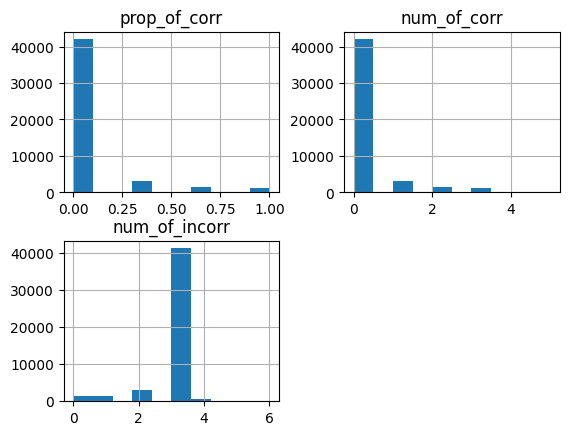

In [20]:
ca.hist();

Можем сделать вывод что описания намного чаще несоответсвуют изображениям если доверять данной оценке.

Теперь посмотрим на оценки экспертов.

In [21]:
ea.describe()

exp_1        exp_2        exp_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

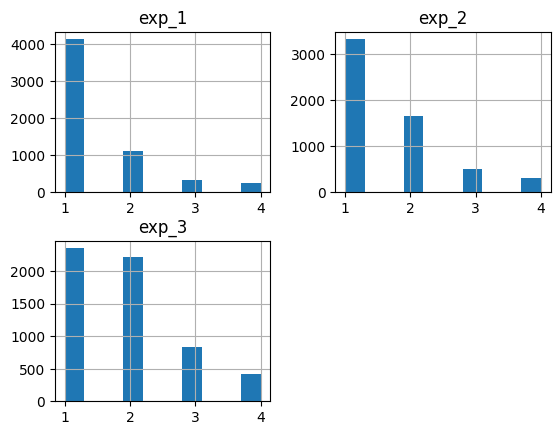

In [22]:
ea.hist();

Оценки экспертов отличаются друг от друга. Первый эксперт в большинстве случаев считает что изображение и запрос совершенно не соответствуют друг другу, в то время как третий хоть и предерживается похожего мнения, но чаще указывает 3 и 4 варианты оценок.

Проверим наличие дупликатов.

In [23]:
train_dataset.duplicated().sum()

0

In [24]:
test_queries.duplicated().sum()

0

In [25]:
ca.duplicated().sum()

0

In [26]:
ea.duplicated().sum()

0

Дупликатов нет.

Выведем несколько изображений из обоих папок.

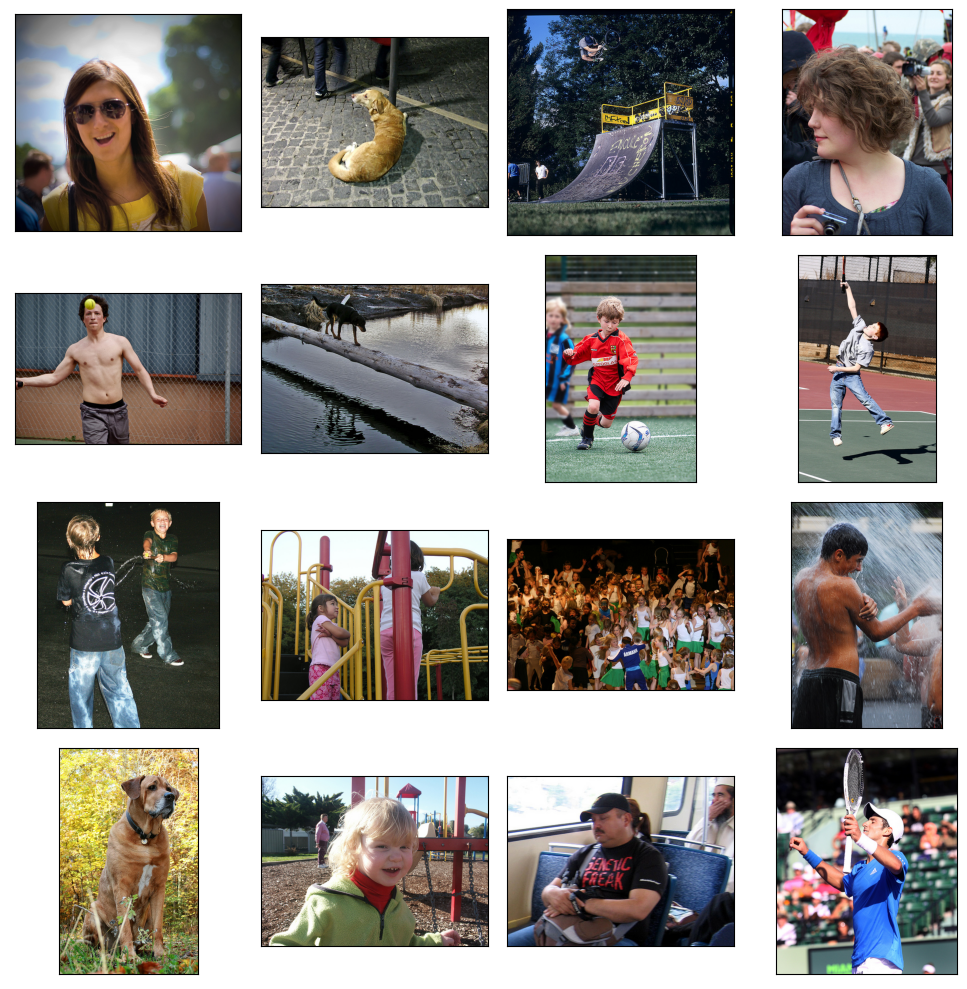

In [27]:
samples_train = list(train_dataset['image'].sample(8))
samples_test = list(test_queries['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывели по 8 изображений из обоих папок. Изображения все отличаются тематикой, размером. Для данного поека есть юридическое ограничение согласно которому нашей модели нельзя выводить изображения с детьми (младше 16 лет), вместо этомы она должна выводить дисклеймер "This image is unavailable in your country in compliance with local laws". Видим что в данных такие изображения имеются.

<a id='analysis_conclusion'></a>
### Вывод по анализу данных

Посмотрели на предоставленные данные. 
- В наличии имеем тренировочный и тестовый датасеты, а так же с оценками экспертов и краудскоринга о соответсвии описания изображению. Помимо этого есть две папки с изображениями, одна для обучения модели, другая для тестирования. Посмотрев на распределение оценок можем сделать вывод что очень много описаний не соответсвуют изображению. Изучив папки с изображениями узнали что у нас есть 1000 изображений для обучения и 100 для теста. Посмотрели на несколько случайных изображений, увидели что присутсвуют изображения которые мы юридически не может отображать используя модель.
- Посмотрели сколько запросов являются уникальными - 977 в тренировочном и 500 в тестовом датасете. Можем сделать вывод что в тестовом датасете как раз 5 уникальных запросов на 1 изображение что совпадает с информормацией которую нам предоставили.
- В дальнейшем нам нужно будет получить целевую переменную, её мы будем создавать из оценок экспертов и собраных с помощью краудсорса. Экспертные оценки находятся в диапазоне 1, 4 где 1 - не совпадает описание, а 4 - полностью совпадает, изображения оценивались тремя экспертами и для каждого у нас есть отдельная колонка для его оценки. Краудсорсинговые оценки отличаются тем что люди отвечали что описание или соответсвует или нет и на основе этих ответов у нас есть 3 колонки:
     -  Доля людей подтвердивших соответсвие.
     -  Количество людей подтвердивших соответсвие.
     -  Колличество людей подтвердивших несоответсвие.

<a id='preprocessing'></a>
## Предобработка

Объеденим тренировочный датасет с оценками экспертов.

In [28]:
train_data = train_dataset.merge(ea, left_on = ['image','query_id'], right_on = ['image','query_id'], how='inner')

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
 3   exp_1       5822 non-null   int64 
 4   exp_2       5822 non-null   int64 
 5   exp_3       5822 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 318.4+ KB


Колличество строк в датафремах совпадало до объеденения, совпадает и после.

Добавим оценки краудсорсинда.

In [30]:
train_data = train_data.merge(ca, left_on = ['image','query_id'], right_on = ['image','query_id'], how='left')

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          5822 non-null   object 
 1   query_id       5822 non-null   object 
 2   query_text     5822 non-null   object 
 3   exp_1          5822 non-null   int64  
 4   exp_2          5822 non-null   int64  
 5   exp_3          5822 non-null   int64  
 6   prop_of_corr   2329 non-null   float64
 7   num_of_corr    2329 non-null   float64
 8   num_of_incorr  2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


Оценки добавили. Теперь нам нужно получить вероятность соответствия изображения тексту. Мы будем использовать оценки как экспертов так и крауда. Для начала произведём масштабирование оценок экспертов. Потом добавим коэффициенты для оценок. Для экспертов примем коэффициент 0.6, а для крауда 0.4. У нас есть пропуски в оценках крауда, в этом случае будем учитывать оценки только экспертов.

In [32]:
def agg_scores(row):
    exp_scores = [row['exp_1'], row['exp_2'], row['exp_3']]
    crowd_prob = row['prop_of_corr']

    scaled_exp_scores = (pd.Series(exp_scores) - 1) / 3

    weight_exp = 0.6
    weight_crowd = 0.4

    if pd.isna(row['prop_of_corr']) == False:
        probability = (scaled_exp_scores.mean() * weight_exp) + (crowd_prob * weight_crowd)
        return probability
    else:
        return scaled_exp_scores.mean()

train_data['probability'] = train_data.apply(agg_scores, axis=1)

In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          5822 non-null   object 
 1   query_id       5822 non-null   object 
 2   query_text     5822 non-null   object 
 3   exp_1          5822 non-null   int64  
 4   exp_2          5822 non-null   int64  
 5   exp_3          5822 non-null   int64  
 6   prop_of_corr   2329 non-null   float64
 7   num_of_corr    2329 non-null   float64
 8   num_of_incorr  2329 non-null   float64
 9   probability    5822 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 500.3+ KB


Получили необходимую колонку с вероятностью соответствия изображения тексту. Можем удалить ненужные для обучения колонки с оценками экспертов и крауда, а так же идентификатор описания.

In [34]:
train_data = train_data.drop(['query_id', 'exp_1', 'exp_2', 'exp_3', 'prop_of_corr', 'num_of_corr', 'num_of_incorr'], axis=1).reset_index(drop=True)

In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_text   5822 non-null   object 
 2   probability  5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


<a id='preprocessing_conclusion'></a>
### Вывод по предобработке

Занялись подготовкой целевой переменной для модели. Для этого нам нужно было получить столбец содержащий вероятность соответсвия описания. Мы решили использовать оценки и экспертов и крауда. Колличество оценок экспертов совпадало с тренировочным датасетом, а крауда в конечном итоге получилось меньше. Оценки экспертов отмасштабировали, крауда у нас уже имелась доля подтвердивших соответствие. После этого приняли коэфициенты оценок и объеденили их в один столбец.

В итоге имеем целевую переменную, необходимую для обучения модели.

<a id='verification'></a>
## Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим список с запрещенными словами.

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_text   5822 non-null   object 
 2   probability  5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


In [37]:
banned = ['young', 'little', 'kid', 'kids', 'baby', 'babies', 'child', 'children', 'boy', 'boys', 'girls', 'girl']

Список создали. Пройдёмся по датафрейму и удалим запрещённые изображения.

In [38]:
to_delete = []

for i, row in train_data.iterrows():
    for word in banned:
        if word in row['query_text'].lower().split(' '):
            if row['probability'] >= 0.5:
                to_delete.append(row['image'])

In [39]:
train_data = train_data[~train_data['image'].isin(to_delete)].reset_index(drop=True)

Удалили строки с запрещёнными изображениями из датасета.

<a id='img_vect'></a>
## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Нужно выбрать какую-либо архитектуру, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Перед векторизацией загрузим изображения с помощью загрузчика данных ImageDataGenerator.

Found 5333 validated image filenames.


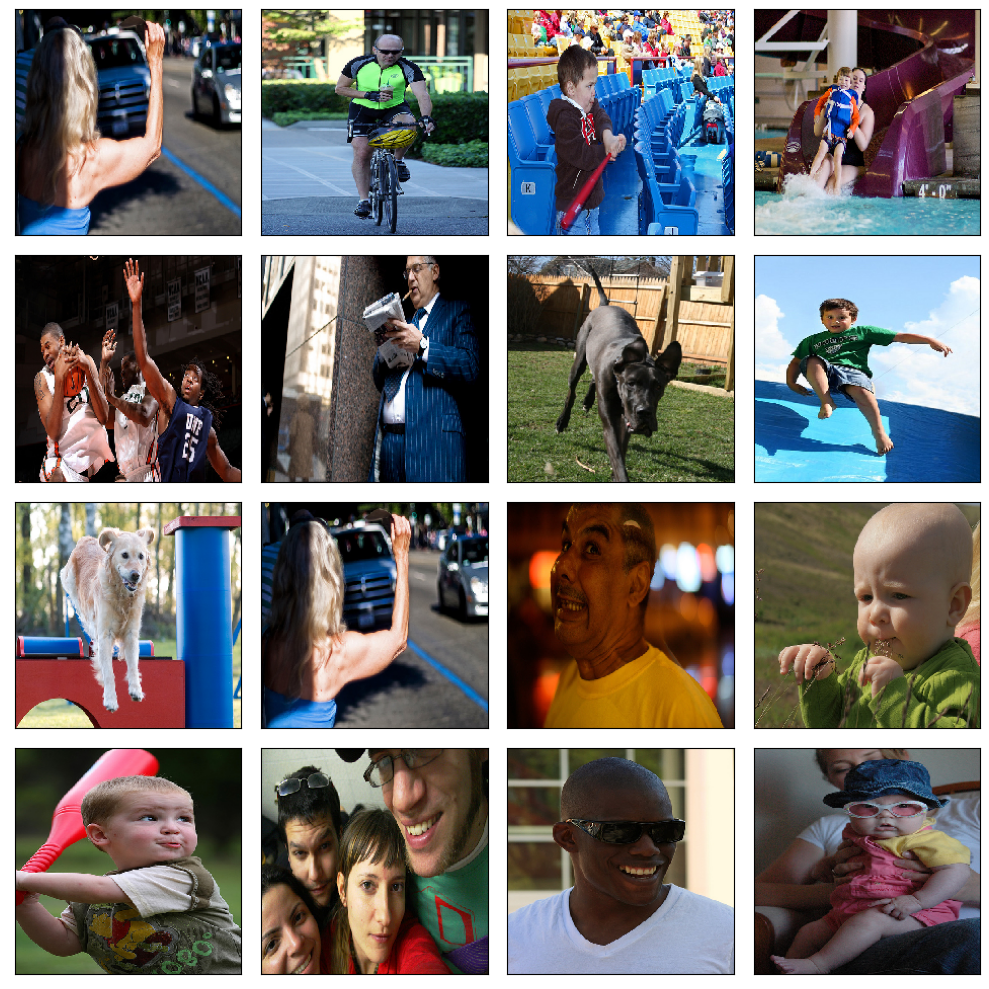

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=Path(PATH, 'train_images'),
        x_col='image',
        y_col='probability',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=12345,
        shuffle=False)

features, target = train_gen_flow.next()

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Данные загрузили. Нашли 5333 изображения. Для векторизации изображений будем использовать предобученную сеть ResNet50 на ImageNet.

In [41]:
def create_model():
    backbone = ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    optimizer=Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

Функцию для создания сети написали. Используем пуллинг GlobalAveragePooling2D, полносвязный слой в конце отсутсвует. В качестве функици потерь выбрали MSE, метрика качества - MAE, оптимизатор - ADAM.

In [42]:
def image_vectorization(model, train):
    predictions = model.predict(train)
    return predictions

Создали функцию для векторизации изображений.

In [43]:
image_embedings = image_vectorization(create_model(), train_gen_flow)

334/334 [==============================] - 144s 429ms/step


In [44]:
print('Размерность вектора изображений', image_embedings.shape)

Размерность вектора изображений (5333, 2048)


Сделали векторизацию и посмотрели на размер массива - (5333, 2048). Тоесть 5333 - колличество изображений, а 2048 - колличество признаков.

<a id='text_vect'></a>
## Векторизация текстов

Перед векторизацией, обработаем текст. Будем использовать nlp - SpaCy. Создадим переменную stop_words для слов неимеющих смысловую нагрузку.

In [45]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuation = string.punctuation

Напишем функцию для обработки текста. Приведём весь текст к нижнему регистру, избавимся от лишних пробелов, удалим знаки препинания, стоп слова и в конце произведём лемматизацию с помощью SpaCy.

In [46]:
def preprocess_text(df):
    text = df['query_text']
    text = " ".join(text.lower().strip().split())
    text = " ".join(text.translate(str.maketrans('', '', punctuation)).split())
    text = ' '.join([word for word in text.split() if word not in stop_words])
    lemmatized_text = " ".join([token.lemma_ for token in nlp(text)])
    return lemmatized_text

In [47]:
train_data['lemmatized_text'] = train_data.apply(preprocess_text, axis=1)

In [48]:
train_data.head()

image  \
0  1056338697_4f7d7ce270.jpg   
1  1262583859_653f1469a9.jpg   
2  2447284966_d6bbdb4b6e.jpg   
3  3030566410_393c36a6c5.jpg   
4  3155451946_c0862c70cb.jpg   

                                          query_text  probability  \
0  A young child is wearing blue goggles and sitt...     0.000000   
1  A young child is wearing blue goggles and sitt...     0.000000   
2  A young child is wearing blue goggles and sitt...     0.133333   
3  A young child is wearing blue goggles and sitt...     0.266667   
4  A young child is wearing blue goggles and sitt...     0.000000   

                               lemmatized_text  
0  young child wear blue goggle sit float pool  
1  young child wear blue goggle sit float pool  
2  young child wear blue goggle sit float pool  
3  young child wear blue goggle sit float pool  
4  young child wear blue goggle sit float pool

Функцию написали и применили, теперь можем приступать к векторизации, будем использовать tf-idf.

In [49]:
count_tf_idf = TfidfVectorizer(max_features=5000, stop_words='english')

In [50]:
tf_idf = count_tf_idf.fit_transform(train_data['lemmatized_text'])

In [51]:
text_vectors = tf_idf.toarray()

In [52]:
print("Размерность вектора:", text_vectors.shape)

Размерность вектора: (5333, 1158)


Произвели векторизацию, получили массив размером (5333, 1158). Тоесть у нас есть 1158 признаков для обучения.

<a id='vect_comb'></a>
## Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной.

In [53]:
train = pd.DataFrame(np.concatenate((image_embedings, text_vectors), axis=1),
                     columns=[f'img_feat_{i}' for i in range(image_embedings.shape[1])] + [f'text_feat_{i}' for i in range(text_vectors.shape[1])])

assert (train.index == train_data.index).all(), "Индексы не совпадают"

train['target'] = train_data['probability']

In [54]:
train.shape

(5333, 3207)

Векторы изображений и текста объеденили с целевой переменной. Получили массив размером (5333, 3207). 5333 строки и 3206 признаков и 1 столбец с целевой переменной.

<a id='fit'></a>
## Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.

In [55]:
RANDOM_STATE = 12345

In [56]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, valid_indices = next(gss.split(X=train.drop(columns=['target']), y=train['target'], groups=train_data['image']))
train_df, valid_df = train.loc[train_indices], train.loc[valid_indices]

In [57]:
features_train = train_df.drop('target', axis=1)
features_valid = valid_df.drop('target', axis=1)
target_train = train_df['target']
target_valid = valid_df['target']

In [58]:
display(features_train.shape)
display(features_valid.shape)
display(target_train.shape)
display(target_valid.shape)

(3751, 3206)

(1582, 3206)

(3751,)

(1582,)

Разбиение на выборки произвели, размеры проверили, всё корректно.

Сделаем масштабирование признаков.

In [59]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

Масштабирование выполнили.

<a id='dummy'></a>
### DummyRegressor

Посмотрим какие результаты покажет DummyRegressor предсказывая всегда среднее значение.

In [60]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
dummy_pred = dummy.predict(features_valid)
print('MSE on valid data:', mean_squared_error(dummy_pred, target_valid))

MSE on valid data: 0.0537202116111817


Получили MSE 0.537

<a id='lr'></a>
### Линейная регрессия

Обучим модель линейной регрессии, в качестве метрика качества будем применять MSE. Так как нам нужно предсказать вероятность находящуюся в диапазоне 0, 1, данная метрика хорошо себя зарекомендовала в таких ситуцаиях и часто используется. Она измерит среднеквадратичное отклонение между предсказанными и фактическими значениями.

In [61]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression()

In [62]:
lr_train_pred = lr_model.predict(features_train)
print('MSE on train data', mean_squared_error(lr_train_pred, target_train))

MSE on train data 0.025895203259242997


In [63]:
lr_pred = lr_model.predict(features_valid)
print('MSE on valid data:', mean_squared_error(lr_pred, target_valid))

MSE on valid data: 7.301903145894176e+23


MSE на валидационной выборке очень большое.

<a id='net'></a>
### Полносвязная сеть

Обучим полносвязную нейронную сеть.

In [64]:
model_nn = Sequential()
model_nn.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],)))
model_nn.add(BatchNormalization())
model_nn.add(Dense(512, activation='tanh'))
model_nn.add(Dense(256, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(128, activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Flatten())
model_nn.add(Dense(1, activation='linear'))


model_nn.compile(loss='mean_squared_error',
                 optimizer = Adam(learning_rate=0.0001),
                 metrics=[MeanSquaredError()])

In [65]:
%%time

model_nn.fit(features_train,
             target_train,
             epochs=100,
             batch_size=48,
             validation_data=(features_valid, target_valid),
             verbose=2)

Epoch 1/100
79/79 - 3s - loss: 0.6953 - mean_squared_error: 0.6953 - val_loss: 0.1444 - val_mean_squared_error: 0.1444 - 3s/epoch - 38ms/step
Epoch 2/100
79/79 - 2s - loss: 0.3038 - mean_squared_error: 0.3038 - val_loss: 0.1831 - val_mean_squared_error: 0.1831 - 2s/epoch - 24ms/step
Epoch 3/100
79/79 - 2s - loss: 0.1947 - mean_squared_error: 0.1947 - val_loss: 0.2146 - val_mean_squared_error: 0.2146 - 2s/epoch - 24ms/step
Epoch 4/100
79/79 - 2s - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 0.2327 - val_mean_squared_error: 0.2327 - 2s/epoch - 24ms/step
Epoch 5/100
79/79 - 2s - loss: 0.1365 - mean_squared_error: 0.1365 - val_loss: 0.2232 - val_mean_squared_error: 0.2232 - 2s/epoch - 24ms/step
Epoch 6/100
79/79 - 2s - loss: 0.1186 - mean_squared_error: 0.1186 - val_loss: 0.2187 - val_mean_squared_error: 0.2187 - 2s/epoch - 24ms/step
Epoch 7/100
79/79 - 2s - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 0.1988 - val_mean_squared_error: 0.1988 - 2s/epoch - 24ms/step
Epoch 

In [66]:
train_predict = model_nn.predict(features_train)
print('MSE on train data', mean_squared_error(target_train, train_predict))

118/118 [==============================] - 0s 3ms/step
MSE on train data 0.004115031393356121


In [67]:
valid_predict = model_nn.predict(features_valid)
print('MSE on test data', mean_squared_error(target_valid, valid_predict))

50/50 [==============================] - 0s 3ms/step
MSE on test data 0.06314664977914564


Обучили полносвязную нейронную сеть. Удалось значительно улучшить MSE как на тестовой так и на тренировочной выборке.

<a id='test'></a>
## Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

In [68]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = test_images,
        directory = Path(PATH, 'test_images'),
        x_col ='image',
        y_col ='probability',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'input',
        seed = 12345,
        shuffle=False)

Found 100 validated image filenames.


In [69]:
test_image_embedings = image_vectorization(create_model(), test_gen_flow)
test_image_embedings.shape

7/7 [==============================] - 3s 355ms/step


(100, 2048)

Получили эмбедденги тестовых изображений.

Напишем функцию для проверки наличия слов из списка banned с запретнными словами.

In [70]:
def check_for_banned_words(text):
    for word in banned:
        if word in text:
            return True
    return False

Функцию написали, теперь приступим к функцию на вход которой будет поступать текст, он будет проверятся на наличие запрещенных слов, если они будут то выведем фразу на экран "This image is unavailable in your country in compliance with local laws". В том случае когда таких слов не будет в тексте мы получим изображение которое модель посчитала наиболее релевантным описанию. Визуально проверим на результат.

4/4 [==============================] - 0s 3ms/step

Three dirt bike racers head over a jump .



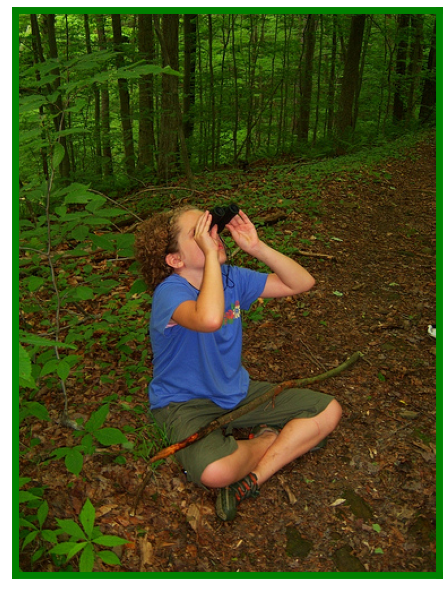

----------------------------------------------------------------------------------------------------
Image: 2670637584_d96efb8afa.jpg, Similarity: 0.591383159160614
----------------------------------------------------------------------------------------------------

a woman dumping water on a small child who is in a pool

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

kids play ultimate Frisbee .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

--------------------------------------------------------------------------

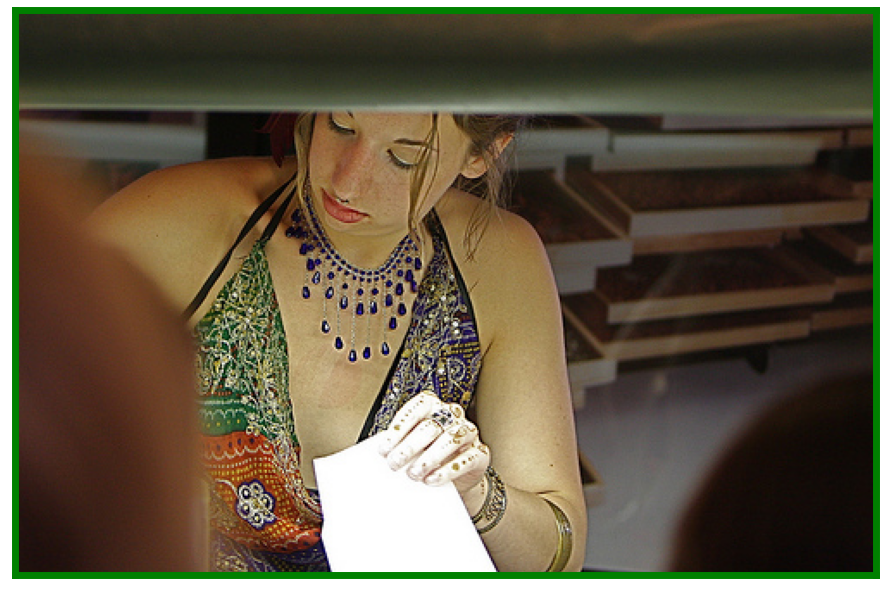

----------------------------------------------------------------------------------------------------
Image: 2687672606_275169c35d.jpg, Similarity: 0.520629346370697
----------------------------------------------------------------------------------------------------

kids are playing in water fountains

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

4/4 [==============================] - 0s 6ms/step

The brown dog is wearing a black collar .



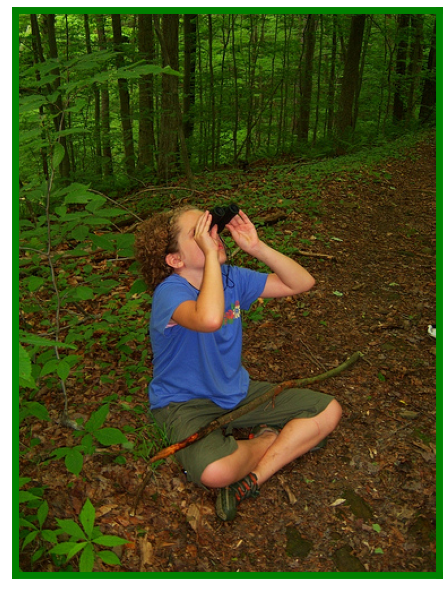

----------------------------------------------------------------------------------------------------
Image: 2670637584_d96efb8afa.jpg, Similarity: 0.6449260115623474
----------------------------------------------------------------------------------------------------

The young boy flings mud at the barefoot girl in the pond .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

----------------------------------------------------------------------------------------------------

A man lies on a blue blanket with a child on his back .

#############################################################################
## THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS ##
#############################################################################

4/4 [==============================] - 0s 

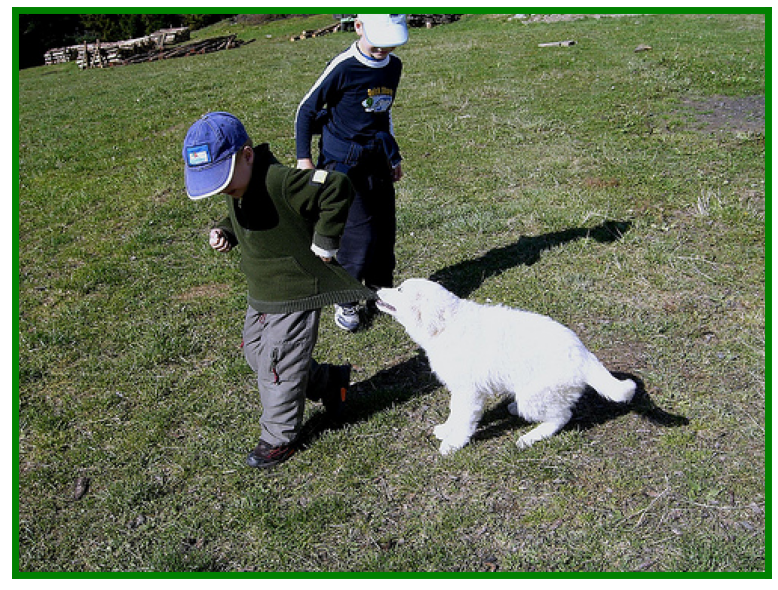

----------------------------------------------------------------------------------------------------
Image: 3122579598_14841c038a.jpg, Similarity: 0.44266027212142944


In [71]:
def inference(text, model, test_images, test_gen_flow, count_tf_idf, scaler, banned):
    if check_for_banned_words(text):
        print('-'*100)
        print()
        print(text)
        print()
        print('#'*77)
        s = 'This image is unavailable in your country in compliance with local laws'.upper()
        print(f'## {s} ##')
        print('#'*77)
        print()
        return None, None
    else:
        tf_idf = count_tf_idf.transform([text])
        test_text_vectors = tf_idf.toarray()
        feature = np.concatenate((test_image_embedings, np.resize(test_text_vectors, (test_image_embedings.shape[0], test_text_vectors.shape[1]))), axis=1)
        feature = scaler.transform(feature)
        predictions = model_nn.predict(feature)

        data = pd.concat((test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='predictions')), axis=1)
        top_image = data.loc[data['predictions'].idxmax(), 'image']

        print()
        print(text)
        print()

        fig = plt.figure(figsize=(15,6))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0

        if text in list(test_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 1, 1)
            relevant_image_path = Path(PATH, 'test_images', top_image)
            image = Image.open(relevant_image_path)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

        print('-'*100)
        
        return top_image, data.loc[data['predictions'].idxmax(), 'predictions']

test_phrases = list(test_queries['query_text'].sample(10))
for phrase in test_phrases:
    image, similarity = inference(phrase, model_nn, test_images, test_gen_flow, count_tf_idf, scaler, banned)
    if image is not None and similarity is not None:
        print(f"Image: {image}, Similarity: {similarity}")


Модель не может корректно выбрать изображения по запросу. Те изображения которые она выберает имеют низкое значение метрики близости и визуально изображения не совпадают описанию.

<a id='conclusion'></a>
## Выводы

Перед нами стояла задача создать систему поиска изображения по запросу. Нам предоставили данные для обучения и тестирования в виде csv файлов и двух папок с изображениями. Изучили файлы, обработали данные. Необходимо было создать целевую переменную, для этого мы использовали экспертные и крудсорсинговые оценки. Удалось получить её, в ней находятся значения в диапазаоне 0, 1 означающие вероятность совпадаения описания с изображением. Учли описания которые могли попадать по юредические ограничения и исключили их и тренировочных данных.

После того как подготовили тренировочные данные, мы векторизировали изображения и тексты, для текстов была так же выполнена лемматизация с помощью SpaCy. Разбили данные на тренировочную и тестовую выборки с помощью GroupShuffleSplit, 70% - тренировочная и 30% - тестовая. Сделали масштабирование признаков.

Выбрали метрику качества для оценки моделей MSE, данная метрика исторически хорошо себя зарекомендовала в случаях когда надо делать предсказания в таком диапазоне. Обучили две модели: Линейная Регрессия и Нейронная Сеть с полносвязными слоями. Нейронная сеть показала значительно лучшие результаты, в последствии остановились на ней.

Сделали тестирования выбранной модели на предоставленных тестовых данных. Модель не справилась с задачей, те изображения которые модель посчитала самыми релеватными имли низкое значение метрики качества и визуально не соответсвовали действительности. Такой проект может быть осуществим если попробовать более продвинутые решения.